# Large-Scale Image Processing On Your Laptop (and elsewhere)

### ImageXD 2017 Tutorial

---
### Goals of this workshop:

* get acquanted with the Python [Dask](http://dask.pydata.org/en/latest/) Library
* learn how to execute basic operations on large images which cannot fit in RAM
* learn about the concepts of lazy evaluation and task scheduling graphs
* learn how to work with [Dask Arrays](http://dask.pydata.org/en/latest/array.html)
* learn how to work with [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html)

---
### Motivation

What is this tutorial about? Researchers across domains get overloaded with image data which their traditional processing workflows are incapable to handle. Usually they are faced with two possible options: 
* move the processing to large machines/clusters
* modify their methods to access the image data only pieces at a time.

<!---* Mechanical Engineering - microbubbles
* Oceanography - sonar, video
* Neuroscience - calcium imaging, fMRI
* etc--->


Scientists like to test out things on their laptops, and later move to clusters, without having to modify their code a lot.

[Dask](http://dask.pydata.org/en/latest/) is a Python Library which makes this possible: 
* can perform computations on images which cannot fit into RAM
* has interface similar to `numpy` and `scipy`
* the same code used on your laptop can be run on a distributed cluster


The Dask library provides several useful objects
* [Dask Arrays](http://dask.pydata.org/en/latest/array.html) (for numpy-like operations) *
* [Dask DataFrames](http://dask.pydata.org/en/doc-test-build/dataframe.html) (for pandas-like operations)
* [Dask Bags](http://dask.pydata.org/en/latest/bag.html) (for unstructured-data-like operations, such as text)
* [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html) (for general functions and operations) *

We will be working with the [cells data](https://github.com/imagexd/imagexd.github.io/blob/master/assets/cells.tar.gz). So set the path to the location where you have unzipped the cells folder.

In [1]:
path = 'data/cells/'

In [2]:
# some preliminary imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Dask Arrays

Dask arrays are similar to numpy arrays, except that they are chunked into small pieces.

In [31]:
import dask.array as da
from dask.array.image import imread

We can read a collection of images into a dask array.

In [4]:
cell_images = imread(path+"*.jpg")

Let's look at it:

In [5]:
cell_images

dask.array<imread, shape=(860, 256, 256, 3), dtype=uint8, chunksize=(1, 256, 256, 3)>

In [6]:
# saving the dimensions
T, m, n, d = cell_images.shape

Each image is a separate chunk.

*The images are not loaded into RAM!!!!*

We can do computations on the dask array as long as individual chunks (and the computations on them) fit into RAM.

Let's  find the mean image:

In [8]:
%%time
cell_images.mean(axis=0)

CPU times: user 24.1 ms, sys: 1.45 ms, total: 25.5 ms
Wall time: 25.8 ms


dask.array<mean_agg-aggregate, shape=(256, 256, 3), dtype=float64, chunksize=(256, 256, 3)>

The above statement creates another dask array, which is not loaded into RAM, i.e. it is not calculated yet. 
It waits for us tell dask explicitly when to do the calculation using the `compute` command.This is called [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation).

In [9]:
%%time
mean_cell_image = cell_images.mean(axis=0).compute()

CPU times: user 11.3 s, sys: 4.31 s, total: 15.6 s
Wall time: 5.04 s


In [10]:
type(mean_cell_image)

numpy.ndarray

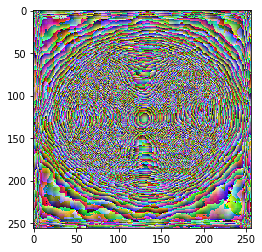

In [11]:
plt.imshow(mean_cell_image)

In [12]:
from dask.diagnostics import ProgressBar

Well, that is pretty but let's do something more meaningful!

***Important: only the final image is stored in RAM, which is smaller than the original collection!***

Note: if we pass a dask array to a function not supporting dask arrays, it often gets converted to an in-memory numpy array and evaluated.

A lot of other functions to perform on images using the [Dask API](http://dask.pydata.org/en/latest/array-api.html).

#### Exercise: visualizing graphs

You can visualize the individual steps of your computation as a graph. For example, this is the graph for computing a mean of an array consisting of 4 chunks:

<center>*Mean of a 2D Array*</center>
<img src="dask_graph.png" width="300" height="200" >

For that you need to install an additional package.

```
pip install graphviz

```
Then you can import `graphviz` in Python and for any dask array run

```
dask_array_name.visualize()
```

Try visualizing the graph for mean of all images. If the visualization does not look good in the notebook you can save it as a `.svg` file and look at the image via your browser:

```
dask_array_name.visualize('graph.svg')
```

#### Exercise: simple calculations
* calculate the mean for each RGB color for each image
* calculate the max for each RGB color for each image
* calculate the min and max across all colors for each image

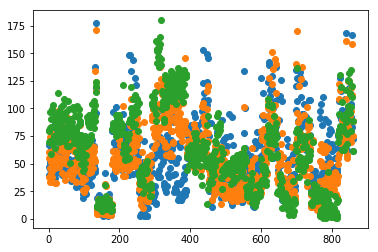

In [11]:
# mean for each RGB color for each image
RGB_means = cell_images.mean(axis=[1,2])
plt.plot(RGB_means,'o')

Visualizing Progress

In [9]:
from dask.diagnostics import ProgressBar

[                                        ] | 0% Completed |  0.0s

/Users/valentina/anaconda/lib/python3.6/site-packages/dask/array/core.py:2054: UserWarning: Increasing number of chunks by factor of 10
  (nparts / max_parts))


[########################################] | 100% Completed |  1.3s


In [22]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
rprof = ResourceProfiler(dt=0.5)

with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    out = res.compute()
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='334dc969-5312-472c-9715-e77f840e886a', ...)

In [12]:
# max for each color for each image

In [13]:
# Single machine progress bar
print(cell_images)
cell_images.mean(axis=[1,2])
res = cell_images.mean(axis=[1,2])
with ProgressBar():
    out = cell_images.mean(axis=[1,2]).compute()

dask.array<imread, shape=(860, 256, 256, 3), dtype=uint8, chunksize=(1, 256, 256, 3)>
[########################################] | 100% Completed |  1.8s


In [13]:
# min across all colors for each image

In [14]:
# max across all colors for each image

In [15]:
# Distributed scheduler ProgressBar

from dask.distributed import Client, progress

client = Client()  # use dask.distributed by default

data = data.persist()  # start computation in the background
progress(data)      # watch progress

data.compute()      # convert to final result when done if desired

NameError: name 'data' is not defined

We observe that some of the images have a very diffent intensity range.

#### A simple cell classifier

We can try to use the means of the colors to distinguish between images of differently colored cells.
Let's find the images which have higher green color than red color.

In [15]:
#average green vs average red 
green_labels = (RGB_means[:,0]<RGB_means[:,1]).compute()

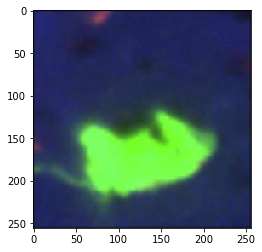

In [16]:
plt.imshow(cell_images[green_labels,:][3,:,:,:])

Key Points:

* dask arrays are not loaded into memory until you start doing computations on them
* computations on dask arrays are not executed until you ask for them via `.compute`()
* passing a `dask.array` to a `numpy` or `matplotlib` function might work but the computation will be done in memory

---
### Perform Principal Component Analysis on a Collection of Images

PCA can be perform by the following steps:
* center the images
* reshape the data into a matrix # features x # observations format
* perform SVD on the data matrix D = USV^T
* flip the signs to make the output deterministic
* reshape the columsn of U into an image format -> these are the principal directions

In [17]:
# center the images
cell_images_centered = cell_images - cell_images.mean(axis = 0)

In [18]:
# create a data matrix - # features x # observations
data = cell_images_centered.reshape((T,m*n*d)).T
print(data.shape)
data

(196608, 860)


dask.array<transpose, shape=(196608, 860), dtype=float64, chunksize=(196608, 1)>

In [19]:
# picture for structure of data to work

In [20]:
help(da.linalg.tsqr)

# Tall-and-Skinny QR algorithm

# It requires that the input array have a
#    single column of blocks, each of which fit in memory.
data.shape


Help on function tsqr in module dask.array.linalg:

tsqr(data, name=None, compute_svd=False)
    Direct Tall-and-Skinny QR algorithm
    
    As presented in:
    
        A. Benson, D. Gleich, and J. Demmel.
        Direct QR factorizations for tall-and-skinny matrices in
        MapReduce architectures.
        IEEE International Conference on Big Data, 2013.
        http://arxiv.org/abs/1301.1071
    
    This algorithm is used to compute both the QR decomposition and the
    Singular Value Decomposition.  It requires that the input array have a
    single column of blocks, each of which fit in memory.
    
    If blocks are of size ``(n, k)`` then this algorithm has memory use that
    scales as ``n**2 * k * nthreads``.
    
    Parameters
    ----------
    
    data: Array
    compute_svd: bool
        Whether to compute the SVD rather than the QR decomposition
    
    See Also
    --------
    
    dask.array.linalg.qr - Powered by this algorithm
    dask.array.linalg.svd - Pow

(196608, 860)

In [21]:
# svd expects only one column block
data = data.rechunk((256,T))
data

dask.array<rechunk-merge, shape=(196608, 860), dtype=float64, chunksize=(256, 860)>

In [22]:
u, s, vt = da.linalg.svd(data)

In [23]:
from dask import compute

In [24]:
%%time
# u = u[:,:10].compute()
u, s, vt = compute(u[:,:10],s[:10],vt[:,:10])

CPU times: user 3min 2s, sys: 1min 20s, total: 4min 22s
Wall time: 1min 9s


In [26]:
from scipy import linalg

In [25]:
%%time
u, s, vt = linalg.svd(data,full_matrices = False)

CPU times: user 2min 14s, sys: 20.6 s, total: 2min 34s
Wall time: 49.3 s


In [ ]:
# I should have an example 

Recall that principal components are unique up to a sign change. So in order that we all obtain the same result we can flip the sings based on vt using the following `svd_flip` function.

In [ ]:
# flip signs based on vt
from sklearn.utils.extmath import svd_flip
u, vt = svd_flip(u,vt)

In [ ]:
# convert the components to back to images
u = u.reshape(256,256,3,10)

In [ ]:
# plot the results
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((u[:,:,:,i]-u.min())/(u.max() - u.min()))
    plt.title('Mode '+str(i+1))

Key Points:
* some dask functions are strict about the form of the chunks
* not all familiar methods are implemented within dask, but you can still run them using the existing base functions
* on a regular laptop complex dask algorithms might not be faster than numpy equivalents but they do not overload the memory

Some of the new functionality of dask for data analysis is implemented within the separate [`dask-ml`](http://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.decomposition.PCA.html) package. It is under active development so expect changes and new stuff!

----
PCA through [`dask-ml`](http://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.decomposition.PCA.html).

In [26]:
#

In [32]:
from dask_ml.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
dX = da.from_array(X, chunks=X.shape)
pca = PCA(n_components=2)
pca.fit(dX)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

[ 0.99244289  0.00755711]
[ 6.30061232  0.54980396]


In [5]:
data.shape

NameError: name 'data' is not defined

In [6]:
pca.fit(data.T)

NameError: name 'data' is not defined

In [7]:
type(pca.components_)

numpy.ndarray

In [8]:
help(pca.fit)

Help on method fit in module dask_ml.decomposition.pca:

fit(X, y=None) method of dask_ml.decomposition.pca.PCA instance
    Placeholder for fit. Subclasses should implement this method!
    
    Fit the model with X.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples and
        n_features is the number of features.
    
    Returns
    -------
    self : object
        Returns the instance itself.



In [9]:
data.shape

NameError: name 'data' is not defined

#### Extra Exercises

**Exercise: chunking performance**

Try using different chunk sizes and compare the speed of the svd computation.

**Exercise: faster svd**

The cells dataset can be loaded into RAM on most laptops so you can compare the speed with running the [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) using the `scikit-learn` package. You will notice that it is actually faster than the dask svd. The reason is that when the data is too big the existing packages by default do not compute the full `svd` , instead they implement a randomized svd algorithm. Compare the speed when passing the parameter `svd_solver = full`. 

Dask has the corresponding implementation in `da.linalg.svd_compressed`. 

In [ ]:
help(da.linalg.svd_compressed)

Compare the speed, compare the results. Can you find the parameters to obtain similar performance?

----
### Perform Complex Operations on a Collection of Images.

We consider the following scenario: 

we have a big pile of images and we need to perform the same pre-processing step to each image and in the end store the result in one array for further processing.

Clearly we can achieve this by writing a `for-loop` which processes each image and stores the result. 

To accomplish this in a distributed manner we can use `dask`'s [delayed](http://dask.pydata.org/en/latest/delayed.html) functionality. It allows to parallelize our own Python functions.

In [ ]:
from dask import delayed

We recall that the images had different intensity ranges: let's rescale them so that they are always between 0 and 255. We can achieve that with the scikit-image [exposure.rescale_intensity](http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity) function.

In [ ]:
from skimage.exposure import rescale_intensity

We can convert a regular Python function to a dask delayed function:

In [ ]:
rescale_intensity_dask = delayed(rescale_intensity)

In [ ]:
# create delayed evaluations
lazy_values = [rescale_intensity_dask(im) for im in cell_images]

In [ ]:
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(m,n,d), dtype=cell_images.dtype) for lazy_value in lazy_values]

In [ ]:
type(arrays)

We can see that the type of this final result is a list and each entry is a `dask array`:

In [ ]:
print(type(arrays))
print(type(arrays[0]))

We can convert them to a dask array:

In [ ]:
stack = da.stack(arrays, axis=0) 

In [ ]:
stack

Note: this chunksize is useful when doing individual operations on images, not across images!

In [ ]:
plt.subplot(1,2,1)
plt.imshow(cell_images[100,:,:,:])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(stack[100,:,:,:])
plt.title('Rescaled Image')

In [ ]:
RGB_max = stack.max(axis = [1,2,3]).compute()

Now the maximum is always 255.

In [ ]:
plt.plot(RGB_max,'ko')

Note: there are alternative approaches to applying a function to a collection of objects in a distributed manner, `dask delayed` is most useful when we want to store the results in a distributed array on which to perform further operations.

Key Points:
* any Python function can be converted to a dask function using `delayed`
* it is most useful to use `dask delayed` when the output can be stored in a dask object
* the power of `dask delayed` is more noticeable on many-core machines or clusters

#### Extra Exercises

**Exercise: segmenting images**

One approach to segment color images is using the k-means algorithm in color space. The `scikit-image` [`segmentation.slic`](http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic) function is a good candidate:

In [ ]:
from skimage import segmentation
help(segmentation.slic)

Apply the function to each image in the collection using `dask delayed`.

Hint: first test the segmentation on a single image to select appropriate parameters.

Compare the speed of this approach to applying the algorithm through a for loop.

#### Exercise: calculating histograms

Use the same approach as above to calculate the histogram for each image. In the new array each image is represented by its histogram. You can further try a clustering algorithm to cluster the images based on their histograms.

----
### Further Resources
* [Scipy 2016 Parallel Python Tutorial](https://www.youtube.com/watch?v=5Md_sSsN51k&list=PLYx7XA2nY5Gf37zYZMw6OqGFRPjB1jCy6&index=13) - comparison of different approaches for parallelization in Python
* [Distributed Images Blog](http://matthewrocklin.com/blog/work/2017/01/17/dask-images) - an example of processing a large image dataset on an Amazon EC2 cluster 
* [Dask on an Amazon EC2 cluster](https://github.com/dask/dask-ec2) - tool to start up a dask EC2 cluster

In [46]:
leaves = imread('data/images_padded/*.jpg')

In [47]:
T, m, n = leaves.shape

In [48]:
print((T,m,n))

(1584, 272, 426)


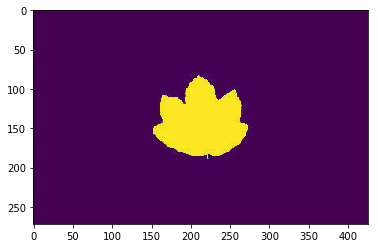

In [49]:
plt.imshow(leaves[0,:,:])

In [50]:
print(leaves)
print(467*526)
res = leaves.astype('float')[7,:,:].compute()
res.shape
# all different sizes

dask.array<imread, shape=(1584, 272, 426), dtype=uint8, chunksize=(1, 272, 426)>
245642


(272, 426)

In [51]:
leaves = leaves.reshape([leaves.shape[0],-1]).rechunk((100,m*n))

In [52]:
1584/99

16.0

In [53]:
leaves

dask.array<rechunk-merge, shape=(1584, 115872), dtype=uint8, chunksize=(100, 115872)>

In [54]:
leaves.shape

(1584, 115872)

In [56]:
pca = PCA(n_components = 5)

In [57]:
print(leaves)
leaves = leaves[:1000,:]
#leaves_np = leaves.compute()
#leaves = da.from_array(leaves_np,chunks = (10,m*n))
print(leaves)
pca.fit(leaves)

dask.array<rechunk-merge, shape=(1584, 115872), dtype=uint8, chunksize=(100, 115872)>
dask.array<getitem, shape=(1000, 115872), dtype=uint8, chunksize=(100, 115872)>


PCA(copy=True, iterated_power=0, n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

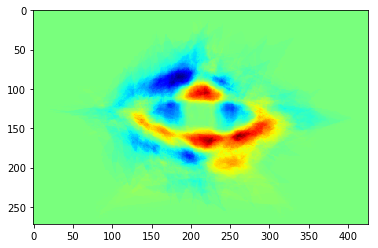

In [63]:
plt.imshow(pca.components_.reshape((-1,m,n))[4,:,:], cmap = 'jet')

In [ ]:
101376

In [15]:
from glob import glob

In [24]:
filenames = glob("data/images/*.jpg")

In [25]:
from skimage.io import imread, imsave

In [26]:
sizes = []
for file in filenames:
    im = imread(file)
    sizes.append(im.shape)

In [27]:
new_size = np.array(sizes).max(axis = 0)


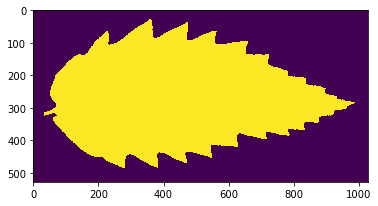

In [265]:
plt.imshow(im)

<class 'numpy.ndarray'>


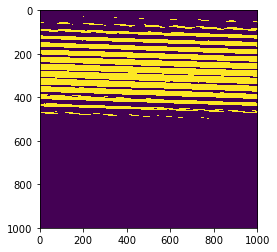

In [266]:
im.resize((1000,1000))
print(type(im))
plt.imshow(im)

In [28]:
def impad(im, new_size):
    pad_sizes = ((int(np.floor((new_size[0]-im.shape[0])/2)),int(np.ceil((new_size[0]-im.shape[0])/2))), (int(np.floor((new_size[1]-im.shape[1])/2)),int(np.ceil((new_size[1]-im.shape[1])/2))))
    im_padded = np.pad(im,pad_sizes,'edge')
    return(im_padded)

In [29]:
for file in filenames:
    im = imread(file)
    imsave('data/images_padded/'+file.split('/')[-1], impad(im, new_size))

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: data/images_padded/69.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


In [19]:
filenames_padded = glob('data/images_padded/*.jpg')
for file in filenames_padded:
    im = imread(file)
    print(im.shape)

(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)

(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)

(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)
(1089, 1706)

In [271]:
help(imsave)

Help on function imsave in module skimage.io._io:

imsave(fname, arr, plugin=None, **plugin_args)
    Save an image to file.
    
    Parameters
    ----------
    fname : str
        Target filename.
    arr : ndarray of shape (M,N) or (M,N,3) or (M,N,4)
        Image data.
    plugin : str
        Name of plugin to use.  By default, the different plugins are
        tried (starting with the Python Imaging Library) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    
    Other parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.



In [30]:
filenames_padded = glob('data/images_padded/*.jpg')
for file in filenames_padded:
    im = imread(file)
    imsave(file,rescale(im, 0.25))

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss 

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/valentina/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, '

In [ ]:
plt.imshow(im)

In [20]:
help(im.rescale)

AttributeError: 'numpy.ndarray' object has no attribute 'rescale'

In [21]:
from skimage.transform import rescale